<a href="https://colab.research.google.com/github/ematala/satellite-segmentation/blob/main/SemiSuperVisedLabeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load & preprocess data

In [1]:
import os, datetime, math
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from seaborn import heatmap
from sklearn.utils import class_weight
from matplotlib import cm
from matplotlib.patches import Patch

In [2]:
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# !pfad angepasst wegen neuem account!
data = np.load('/content/drive/MyDrive/Colab Notebooks/satellite-segmentation/data/train.npz')['bands']
labels = np.load('/content/drive/MyDrive/Colab Notebooks/satellite-segmentation/data/train.npz')['lulc']

classes = np.array(['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland', 'Snow and Ice'])

test = np.load('/content/drive/MyDrive/Colab Notebooks/satellite-segmentation/data/public_test.npz')['bands']

In [5]:
# parameters

# set the pixel to extract
PIXEL_X = 16
PIXEL_Y = 16

# training iterations
ITERS = 2000

# random seed
SEED = 42

# use gpu if possible
TASK = 'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'

In [6]:
def preprocess(x, y, labels=None):
  x = x[y != 0, :, :, :, :] if labels == 'exclude_no_data' else x[y == 0, :, :, :, :] if labels == 'only_no_data' else x
  y = y[y != 0] if labels == 'exclude_no_data' else y[y == 0] if labels == 'only_no_data' else y

  x_train, x_val, y_train, y_val = train_test_split(x[:, :, PIXEL_X, PIXEL_Y, :].reshape((x.shape[0], x.shape[1] * x.shape[-1])), y, test_size=0.2, random_state=42, stratify = y)

  return x_train, x_val, y_train, y_val

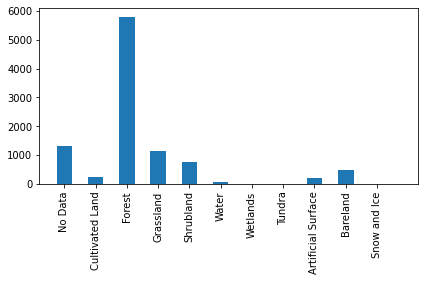

In [7]:
plt.hist(labels, bins=list(range(len(classes) + 1)), width=0.5, align='mid')
plt.xticks(ticks=[i + 0.25 for i in range(len(classes))], labels=classes, rotation=90)
plt.tight_layout()
plt.show()

# Try predicting labels from the model

In [8]:
!pip install catboost
from catboost import CatBoostClassifier

In [9]:
# use only labelled data for training
x_train, x_val, y_train, y_val = preprocess(data, labels, 'exclude_no_data')
f'train: {x_train.shape} {y_train.shape}, validation: {x_val.shape} {y_val.shape}'

'train: (6953, 72) (6953,), validation: (1739, 72) (1739,)'

In [10]:
cbm = CatBoostClassifier(learning_rate=0.1, iterations=ITERS, random_seed=SEED, logging_level='Silent', task_type=TASK)
# fit on labelled data
cbm.fit(x_train, y_train)

In [11]:
# evaluate the model
cbm_train = cbm.predict(x_train).reshape(-1)
cbm_val = cbm.predict(x_val).reshape(-1)

print('Training\n')
print(f'Accuracy: {accuracy_score(y_train, cbm_train)*100}')
print(f'F1-Score: {f1_score(y_train, cbm_train, average=None)*100}')
print(classification_report(y_train, cbm_train))

print('\n')

print('Validation\n')
print(f'Accuracy: {accuracy_score(y_val, cbm_val)*100}')
print(f'F1-Score: {f1_score(y_val, cbm_val, average=None)*100}')
print(classification_report(y_val, cbm_val))

Training

Accuracy: 100.0
F1-Score: [100. 100. 100. 100. 100. 100. 100.]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       190
           2       1.00      1.00      1.00      4637
           3       1.00      1.00      1.00       900
           4       1.00      1.00      1.00       616
           5       1.00      1.00      1.00        46
           8       1.00      1.00      1.00       174
           9       1.00      1.00      1.00       390

    accuracy                           1.00      6953
   macro avg       1.00      1.00      1.00      6953
weighted avg       1.00      1.00      1.00      6953



Validation

Accuracy: 83.89879240943071
F1-Score: [61.17647059 92.80131633 68.98148148 42.44897959 66.66666667 63.01369863
 77.31958763]
              precision    recall  f1-score   support

           1       0.70      0.54      0.61        48
           2       0.89      0.97      0.93      1159
           3       0.72     

In [12]:
# fit the model on full labelled data, i. e. combine the splits
cbm.fit(np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)))

In [13]:
# predict labels for unlabelled data
unlabelled_data_transformed = data[labels == 0, :, PIXEL_X, PIXEL_Y, :].reshape((data[labels == 0, :, :, :, :].shape[0], data.shape[1] * data.shape[-1]))
predicted_labels = cbm.predict(unlabelled_data_transformed).reshape(-1)

In [14]:
# train the model on labelled training instances and add predicted labels
x_train = np.concatenate((x_train, unlabelled_data_transformed))
y_train = np.concatenate((y_train, predicted_labels))
cbm.fit(x_train, y_train)

In [15]:
# evaluate the model
cbm_train = cbm.predict(x_train).reshape(-1)
cbm_val = cbm.predict(x_val).reshape(-1)

print('Training\n')
print(f'Accuracy: {accuracy_score(y_train, cbm_train)*100}')
print(f'F1-Score: {f1_score(y_train, cbm_train, average=None)*100}')
print(classification_report(y_train, cbm_train))

print('\n')

print('Validation\n')
print(f'Accuracy: {accuracy_score(y_val, cbm_val)*100}')
print(f'F1-Score: {f1_score(y_val, cbm_val, average=None)*100}')
print(classification_report(y_val, cbm_val))

Training

Accuracy: 100.0
F1-Score: [100. 100. 100. 100. 100. 100. 100.]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       198
           2       1.00      1.00      1.00      5656
           3       1.00      1.00      1.00      1035
           4       1.00      1.00      1.00       654
           5       1.00      1.00      1.00        48
           8       1.00      1.00      1.00       218
           9       1.00      1.00      1.00       452

    accuracy                           1.00      8261
   macro avg       1.00      1.00      1.00      8261
weighted avg       1.00      1.00      1.00      8261



Validation

Accuracy: 84.07130534790109
F1-Score: [62.22222222 92.86885246 68.89952153 43.44262295 66.66666667 64.86486486
 76.28865979]
              precision    recall  f1-score   support

           1       0.67      0.58      0.62        48
           2       0.88      0.98      0.93      1159
           3       0.75     

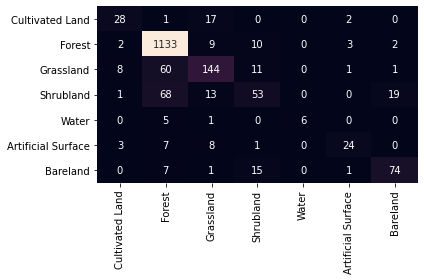

In [16]:
# confusion matrix
preds = cbm_val
preds_df = pd.DataFrame({'true':y_val, 'preds':preds})
conf_df = pd.DataFrame(confusion_matrix(preds_df['true'], preds_df['preds']), index=classes[np.unique(preds)], columns=classes[np.unique(preds)])
heatmap(conf_df, annot=True, fmt='d', cbar=False)

plt.tight_layout()
plt.show()

In [17]:
# final step: fit the model on all labelled data
labelled_data_transformed = data[labels != 0, :, PIXEL_X, PIXEL_Y, :].reshape((data[labels != 0, :, :, :, :].shape[0], data.shape[1] * data.shape[-1]))
labelled_data_labels = labels[labels != 0]
cbm.fit(labelled_data_transformed, labelled_data_labels)

In [18]:
# predict labels for unlabelled data
unlabelled_data_transformed = data[labels == 0, :, PIXEL_X, PIXEL_Y, :].reshape((data[labels == 0, :, :, :, :].shape[0], data.shape[1] * data.shape[-1]))
predicted_labels = cbm.predict(unlabelled_data_transformed).reshape(-1)

# overwrite existing labels without label
new_labels = labels.copy()
new_labels[labels == 0] = predicted_labels

In [19]:
# fit model with full data
full_data_transformed = data[:, :, PIXEL_X, PIXEL_Y, :].reshape((data.shape[0], data.shape[1] * data.shape[-1]))
cbm.fit(full_data_transformed, new_labels)

## Visualize results

In [20]:
test_transformed = []
for i in range(500):
  for j in range(500):
    pixel = test[:, i, j, :].reshape((72,))
    test_transformed.append(pixel)

test_transformed = np.array(test_transformed)

pred = cbm.predict(test_transformed).reshape((500, 500))

# TODO Bookmark

In [21]:
# todo transform test data to model shape
tmp = np.moveaxis(test, 0, -1).reshape((250000, 72), order='A')
np.all(tmp == test_transformed)

False

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


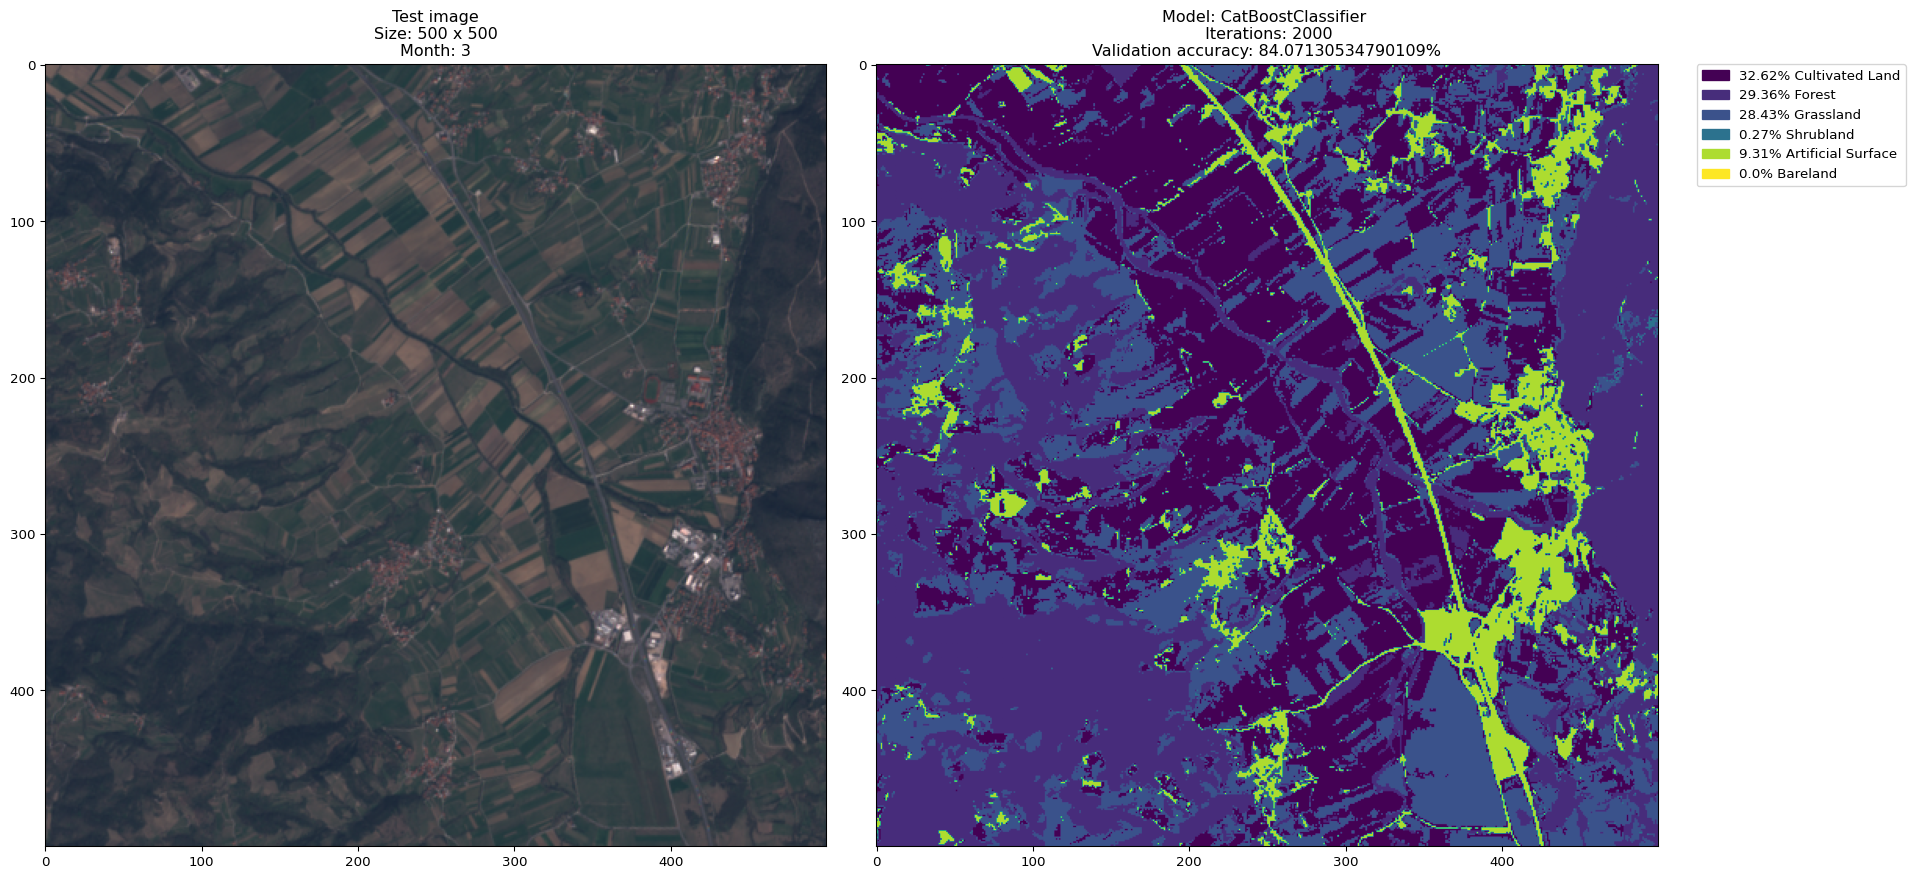

In [22]:
# plot image and predicted labels
month = 3

f, (sat, lulc) = plt.subplots(1, 2, figsize=(20,10), dpi=96, tight_layout=True)

band = 0.5 + 2.5 * (np.flip(test[month, :, :, :3], -1) + .3 - 0.5)
sat.imshow(band, cmap='gray')
sat.set_title(f'Test image\nSize: 500 x 500\nMonth: {month}')

im = lulc.imshow(pred)
colors = [im.cmap(im.norm(value)) for value in np.unique(pred).astype(int)]
portions = np.array([round(x, 2) for x in np.histogram(pred, bins=range(len(classes)))[0] / pred.shape[0] ** 2 * 100])[np.unique(pred).astype(int)]
patches = [Patch(color=colors[i], label=f'{portions[i]}% {classes[np.unique(pred).astype(int)[i]]}') for i in range(len(np.unique(pred).astype(int)))]

lulc.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
lulc.set_title(f'Model: CatBoostClassifier \n Iterations: {ITERS}\nValidation accuracy: {accuracy_score(y_val, cbm_val)*100}%')

plt.show()

In [23]:
# save plot, model and predictions
f.savefig('/content/drive/MyDrive/Colab Notebooks/satellite-segmentation/models/cbm/plot.png')
np.save('/content/drive/MyDrive/Colab Notebooks/satellite-segmentation/models/cbm/predictions.npy', pred)
cbm.save_model('/content/drive/MyDrive/Colab Notebooks/satellite-segmentation/models/cbm/model')

# Try different clustering methods for labeling

In [24]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram
import seaborn as sns

In [25]:
# reshape data to (n, channels x months)
reshaped_data = data[:, :, PIXEL_X, PIXEL_Y, :].reshape((data.shape[0], data.shape[1] * data.shape[-1]))

In [26]:
N_CLUSTERS = 10
reshaped_data = reshaped_data[labels == 0, :]

In [27]:
# perform PCA to reduce dimensionality and visualize data
pca = PCA().fit_transform(reshaped_data)

In [28]:
# hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=N_CLUSTERS).fit_predict(reshaped_data)

In [29]:
# kmeans clustering
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=SEED).fit_predict(reshaped_data)

In [30]:
# DBSCAN clustering
dbscan = DBSCAN(min_samples=7).fit_predict(reshaped_data)

In [31]:
#pd.DataFrame({'true': labels[labels==0], 'hierarchical': clustering, 'kmeans': kmeans, 'dbscan': dbscan})

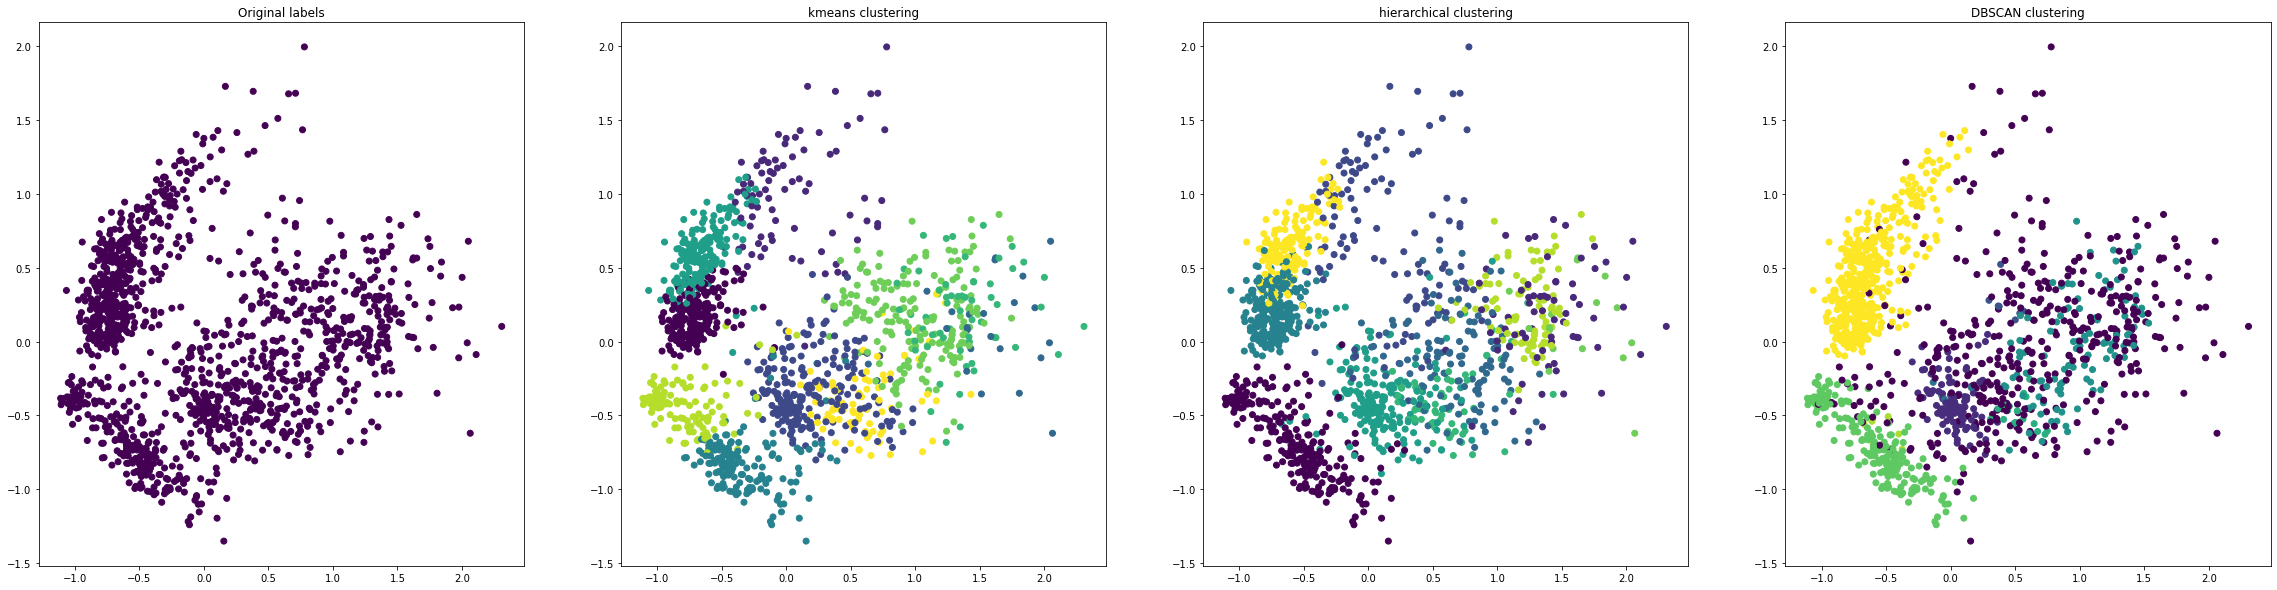

In [32]:
# visualize clustering methods

# dimensions to plot
DIM_X = 0
DIM_Y = 1

fig, (original, kmean, hierarchical, db) = plt.subplots(1, 4, figsize=(40, 10))
original.scatter(pca[:, DIM_X], pca[:, DIM_Y], c=labels[labels==0])
original.set_title('Original labels')
kmean.scatter(pca[:, DIM_X], pca[:, DIM_Y], c=kmeans)
kmean.set_title('kmeans clustering')
hierarchical.scatter(pca[:, DIM_X], pca[:, DIM_Y], c=clustering)
hierarchical.set_title('hierarchical clustering')
db.scatter(pca[:, DIM_X], pca[:, DIM_Y], c=dbscan)
db.set_title('DBSCAN clustering')
plt.show()

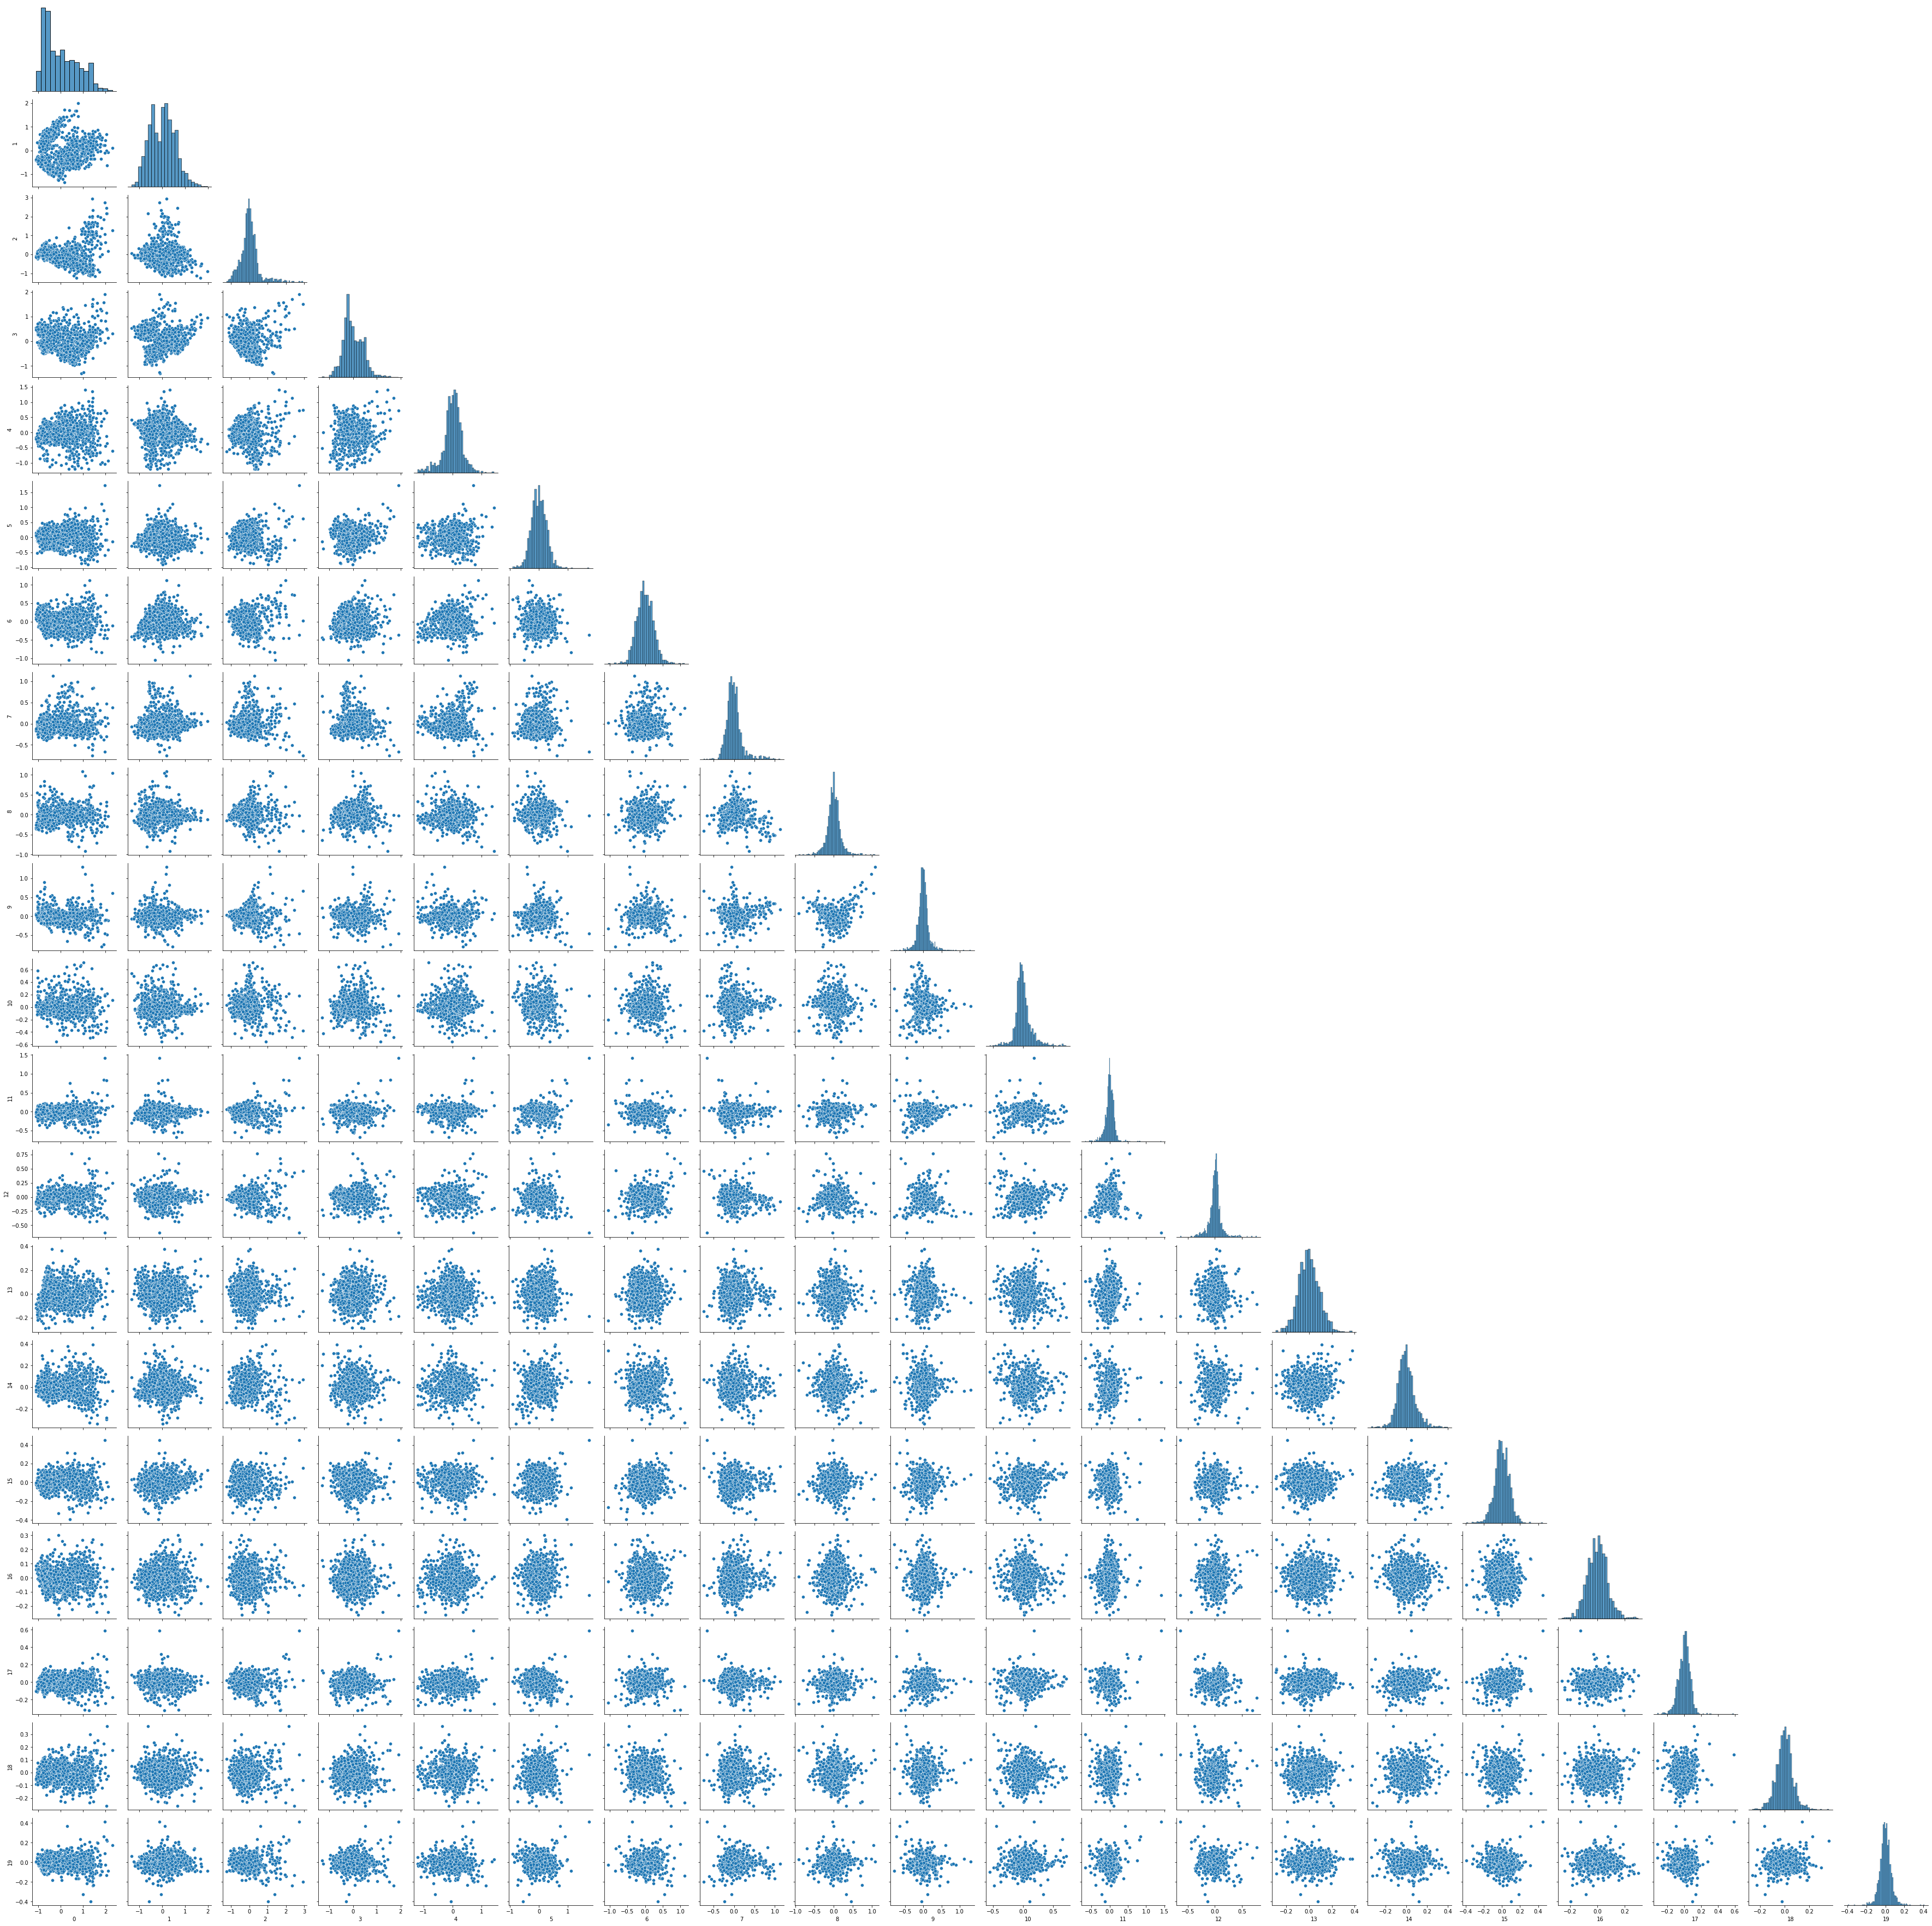

In [33]:
g = sns.PairGrid(pd.DataFrame(pca[:, 0:20]), diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)

# Try KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# reshape data to (n, channels x months)
reshaped_data = data[:, :, PIXEL_X, PIXEL_Y, :].reshape((data.shape[0], data.shape[1] * data.shape[-1]))

In [ ]:
# perform PCA to reduce dimensionality and visualize data
pca = PCA().fit_transform(reshaped_data)

In [ ]:
x_train, x_val, y_train, y_val = preprocess(data, labels)

In [ ]:
knn = KNeighborsClassifier(weights='distance').fit(x_train, y_train)

In [ ]:
# evaluate the model
print(f'Training accuracy: {accuracy_score(y_train, knn.predict(x_train))*100}')
print(f'Validation accuracy: {accuracy_score(y_val, knn.predict(x_val))*100}')

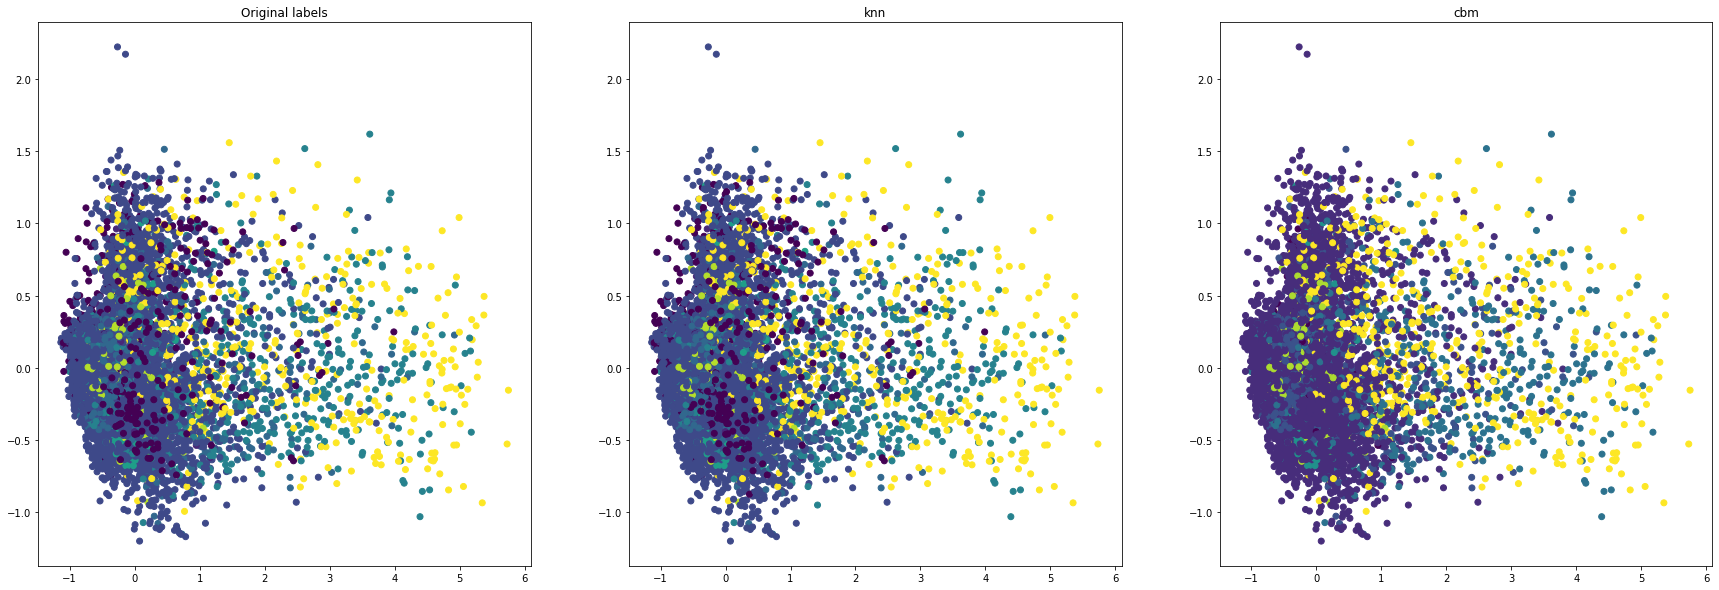

In [40]:
# visualize knn

knn_pred = knn.predict(reshaped_data)
cbm_pred = cbm.predict(reshaped_data).reshape(-1)

# dimensions to plot
DIM_X = 0
DIM_Y = 4

fig, (original, knns, cbms) = plt.subplots(1, 3, figsize=(30, 10))
original.scatter(pca[:, DIM_X], pca[:, DIM_Y], c=labels)
original.set_title('Original labels')
knns.scatter(pca[:, DIM_X], pca[:, DIM_Y], c=knn_pred)
knns.set_title('knn')
cbms.scatter(pca[:, DIM_X], pca[:, DIM_Y], c=cbm_pred)
cbms.set_title('cbm')
plt.show()